In [1]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "ncomponents-80_nregions-266"

i_path = Path(config["parcellations"]) / ATLAS
atlas = Atlas.from_path(i_path)

k = 3
REFNET = np.unique(atlas.macro_labels)
INTER = REFNET
#REFNET = ("Default",)
#INTER = ("Default",)

sns.reset_defaults()
# TODO Deconfounding in the pipeline?

In [2]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k)
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    net="".join(REFNET),
    inter="".join(INTER)
)

if len(run_path.name) > 55:
    print("too long")
    run_path = make_run_path(
        config["output_dir"],
        k=k,
        feat="fc",
        atlas=ATLAS,
        net="all"
    )
    
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 9 subjects because of lacking MMMSE
too long


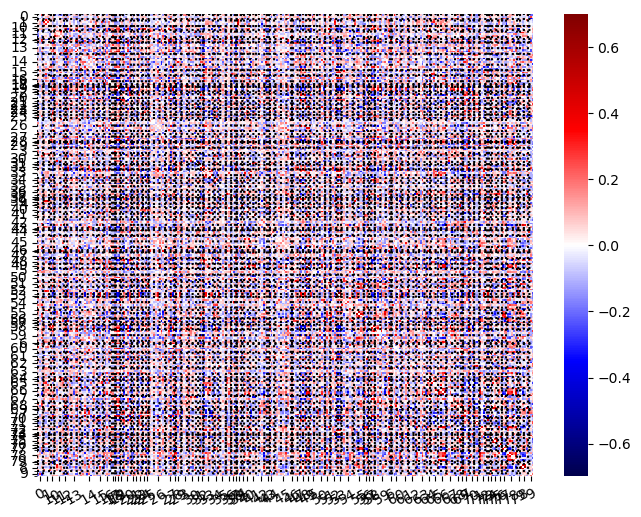

In [3]:
plot_matrix(matrices[1], atlas)
plt.show()

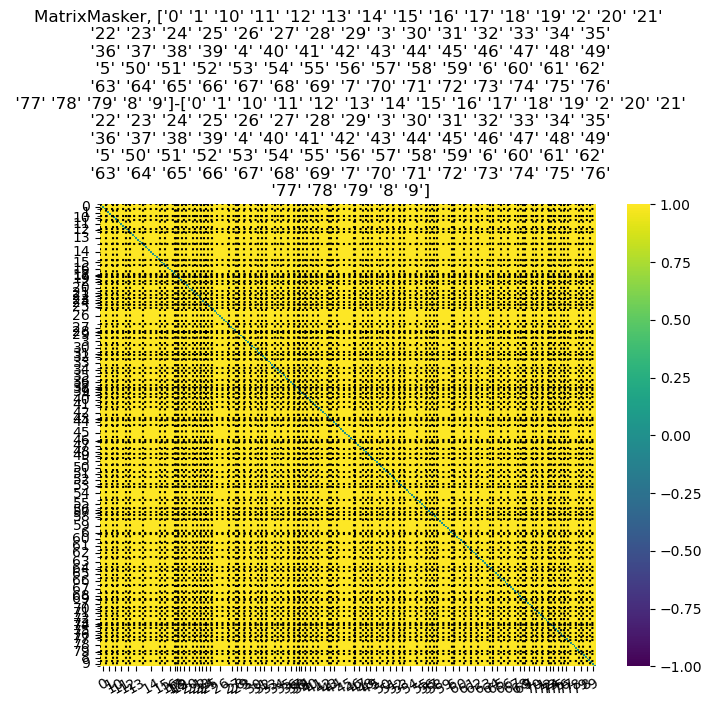

In [4]:
masker = MatrixMasker(REFNET, INTER, atlas=atlas).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

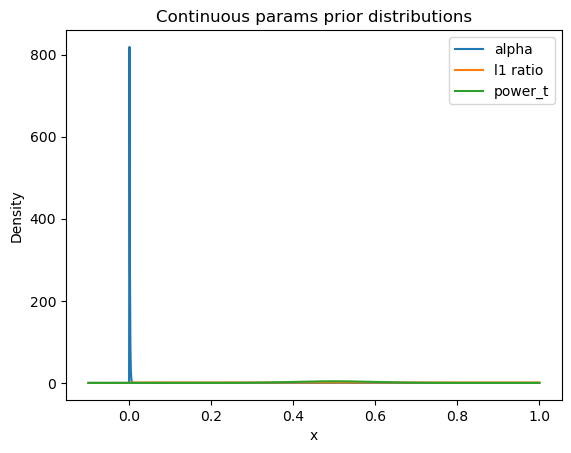

In [5]:
from scipy import stats

lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [6]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
}

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from cogpred.supervised import macro_f1
from sklearn.neighbors import NearestNeighbors

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)


clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER, atlas=atlas)),
    ("scaler", preprocessing.StandardScaler()),
    #("smote", SMOTE(
    #    random_state=1234,
    #    sampling_strategy="minority",
    #    k_neighbors=NearestNeighbors(n_neighbors=2, n_jobs=-1)
    #)),
    ("classifier", sgd)
    ],
    verbose=False
)

inner_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=10,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [16]:
y = metadata.cluster_label.values
search.fit(matrices, y, groups=metadata.CEN_ANOM.values)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 10 candidates, totalling 80 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
4,21.940104,2.316502,0.153961,0.085292,0.001314,0.123068,log_loss,0.350967,"{'classifier__alpha': 0.0013139934387144442, '...",0.305953,0.269081,0.452509,0.336067,0.321711,0.371116,0.298851,0.324370,0.334957,0.052320,1
6,19.906771,2.161533,0.144396,0.089898,0.000193,0.482061,modified_huber,0.560676,"{'classifier__alpha': 0.0001933100578217634, '...",0.311921,0.267989,0.358282,0.356207,0.312185,0.272790,0.358449,0.210164,0.305998,0.049763,2
7,25.510680,2.432738,0.146362,0.086506,0.000007,0.698539,modified_huber,0.553717,"{'classifier__alpha': 7.110013407927153e-06, '...",0.307812,0.244041,0.344755,0.316073,0.340036,0.300520,0.238548,0.237532,0.291165,0.041998,3
9,25.232617,4.819974,0.146906,0.096030,0.000674,0.884726,log_loss,0.591817,"{'classifier__alpha': 0.000674365870707518, 'c...",0.260372,0.262007,0.322930,0.289277,0.324425,0.249338,0.246115,0.183333,0.267225,0.042923,4
8,20.108849,2.072613,0.138262,0.086552,0.000156,0.830286,modified_huber,0.494273,"{'classifier__alpha': 0.00015565470766532458, ...",0.278949,0.226389,0.359815,0.292991,0.330986,0.291775,0.183058,0.170732,0.266837,0.063348,5
1,22.425526,3.362844,0.218271,0.100040,0.000218,0.860217,hinge,0.331347,"{'classifier__alpha': 0.00021752476313827227, ...",0.283260,0.206057,0.361766,0.313521,0.301020,0.301302,0.210570,0.151055,0.266069,0.065267,6
2,24.687799,3.188309,0.178492,0.104538,0.000414,0.901344,log_loss,0.61007,"{'classifier__alpha': 0.0004141433628852421, '...",0.280588,0.246747,0.296676,0.285669,0.313798,0.291359,0.218821,0.189969,0.265453,0.040068,7
3,22.173678,2.032689,0.154655,0.081270,0.00008,0.691335,hinge,0.557582,"{'classifier__alpha': 8.005084102476663e-05, '...",0.289409,0.222766,0.346694,0.294376,0.324454,0.264911,0.183560,0.187654,0.264228,0.057076,8
5,68.852072,52.676585,0.142822,0.091505,0.0025,0.895679,log_loss,0.586649,"{'classifier__alpha': 0.0024995779584170053, '...",0.251571,0.243271,0.302502,0.278487,0.316890,0.287037,0.223587,0.189877,0.261653,0.039824,9
0,151.976346,156.219602,0.246112,0.194898,0.00174,0.984627,log_loss,0.587207,"{'classifier__alpha': 0.0017402311925260737, '...",0.256720,0.224381,0.259565,0.259732,0.299311,0.270153,0.265908,0.185841,0.252702,0.031695,10


In [17]:
est = search.best_estimator_
reg = est.named_steps["classifier"]
masker = est.named_steps["matrixmasker"]
atlas = masker.atlas

In [18]:
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

n_regions = sum(map(net_select, atlas.macro_labels))

In [19]:
from nilearn.connectome import vec_to_sym_matrix

def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    if atlas.name == "schaefer200":
        macro_labels = list(map(region_split, regions))
    else:
        macro_labels = regions
    
cats = ("stable", "slow", "steep")
for i in range(k):

    coefs = reg.coef_[i, :]

    # Perform Hauf transform to make coefs interpretable
    X = masker.transform(matrices)
    patterns = np.cov(X.T) @ coefs

    arr = vec_to_sym_matrix(patterns, diagonal=np.zeros(n_regions))
    cat = cats[i]
    axes = plot_matrix(
        np.where(np.abs(arr) > 0, arr, 0),
        MockAtlas(),
        cmap="RdBu_r",
        bounds=(-10, 10),
        macro_labels=False
    )
    axes.set_title(f"Linear model weights for {cat} class")
    plt.show()

KeyboardInterrupt: 

In [ ]:
test_scores = cross_val_score(
    search,
    matrices,
    y,
    cv=outer_cv.split(matrices, y, groups=metadata.CEN_ANOM.values),
    n_jobs=8,
    scoring=macro_f1,
    verbose=1,
    params={"groups": metadata.CEN_ANOM.values} # This is for inner cv
)
test_scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

array([0.31869919, 0.37785658, 0.41216931, 0.32903307, 0.33500647,
       0.32748333, 0.4032049 , 0.34426414])

In [ ]:
import joblib
cv_results.to_csv(run_path / "cv_results.csv")
#joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-msdl_net-all/best_estimator.joblib']